In [ ]:
from __future__ import print_function
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from torch.utils.tensorboard import SummaryWriter
import tqdm

/home/mohammadreza/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Load

Several transformations can be combined together. Popular transformations:
- `torchvision.transforms.Normalize(mean, std, inplace=False)`
- `torchvision.transforms.ToTensor()` - Converts a PIL Image or `numpy.ndarray` (H x W x C) in the range `[0, 255]` to a `torch.FloatTensor` of shape (C x H x W) in the range `[0.0, 1.0]`

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms


transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                               ]) # Translate data to tensor and normalize all the value around 0.5

ds_train = datasets.MNIST('./ai-iuthschool/data', train = True, download=False, transform=transform)
ds_test = datasets.MNIST('./ai-iuthschool/data', train = False, download=False, transform=transform)

# trainloader: The helpful properties allows to deal with tensors, is dataloader

trainloader = torch.utils.data.DataLoader(ds_train, batch_size=512,
                                         shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(ds_test, batch_size=512,
                                        shuffle=False, num_workers=4)

DataLoaders provide convenient interface for training loops:

```python
    for epoch in range(num_epochs):
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            batch_X = ...
            batch_y = ...
            ...
            
```
or
```python
    batch_X, batch_y = iter(trainloader).next()
```

In [ ]:
!pwd

/media/mohammadreza/A8043D33043D05BA/mlhep-NAHAEE/section-2/2.4-pytorch-intro


In [ ]:
print('Train', ds_train, '\nTest',ds_test)

Train Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           ) 
Test Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [ ]:
iterdata = iter(trainloader)
X_batch, y_batch = next(iterdata)

In [ ]:
print(f'X BATCH SIZE: \n{X_batch.size()}', '\n' f'X BATCH DIMENSION: \n{X_batch.dim()}',
     '\n' f'X BATCH SHAPE: \n{X_batch.shape}')

X BATCH SIZE: 
torch.Size([512, 1, 28, 28]) 
X BATCH DIMENSION: 
4 
X BATCH SHAPE: 
torch.Size([512, 1, 28, 28])


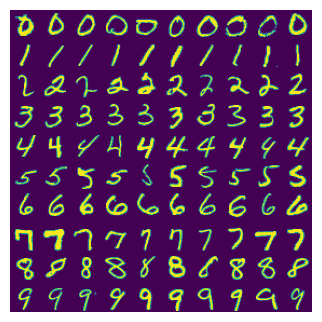

In [ ]:
plt.figure(figsize=(4, 4), dpi=100)
plt.axis('off')

plt.imshow(
    torch.transpose(
        torch.cat(
            [X_batch[y_batch == c][:10] for c in range(10)], axis=0
        ).reshape(10, 10, 28, 28),
        1, 2
    ).reshape(280, 280)
)
plt.show()

**Automatic Differentiation**  

To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad = True` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.  

You can turn off gradients for a block of code with the `torch.no_grad()` context:


```python
x = torch.zeros(1, requires_grad=True)
with torch.no_grad():
    y = 2 * x
y.requires_grad
False
```
                   

In [ ]:
x = torch.randn([2, 2], requires_grad=True) #3 * 2 matrix initialized by random numbers
x

tensor([[-0.7382, -0.1826],
        [-1.2881,  1.3321]], requires_grad=True)

In [ ]:
y = x**2
print(y)

tensor([[2.7701, 1.3275],
        [0.0733, 0.0258]], grad_fn=<PowBackward0>)


In [ ]:
# What was the function that has created the graph.
y.grad_fn
# <PowBackward> should be sent as operator in upward direction nodes

In [ ]:
z = y.mean() # (y11 + y12 + y21 + y22) / 4
z

tensor(1.0492, grad_fn=<MeanBackward0>)

In [ ]:
z.grad_fn

In [ ]:
print(x.grad)

None


`x.grad` is none since we have not calculated gradient using `backward()`.
To calculate the gradients, you need to run the `.backward` method on a variable `z`, for example. This will calculate the gradient for `z` with respect to `x`

$$\frac{\partial z}{\partial x}=\frac{\partial}{\partial x}\left[\frac{1}{n} \sum_{i}^{n} x_{i}^{2}\right]=\frac{x}{2}$$

In [ ]:
z.backward()
print(x.grad)
print(x/2)

tensor([[ 0.8322, -0.5761],
        [ 0.1354,  0.0803]])
tensor([[ 0.8322, -0.5761],
        [ 0.1354,  0.0803]], grad_fn=<DivBackward0>)


 ## Loss and Autograd
When we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated.

In [ ]:
print('cuda' if torch.cuda.is_available() else 'using cpu')

cuda


In [ ]:
if torch.cuda.is_available():
    #cuda_id = get_random_gpu()
    device = f'cuda:{0}'
    print(f'selected {device}')

else:
    device = 'cpu'
    print('WARNING: using cpu')

selected cuda:0


In [ ]:
model = nn.Sequential(

    # SOLUTION
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
).to(device)
# raise NotImplementedError()
print('Weight shapes:')
for w in model.parameters():
    print(' ', w.shape)

Weight shapes:
  torch.Size([100, 784])
  torch.Size([100])
  torch.Size([10, 100])
  torch.Size([10])


If we give our batch to the model, we get an exception of dimension mismatch, since batch dimensions are 512 x 28 x 28 x 1, while model expects 512 x 784, so we need to flatten the trailing dimensions. You can use method `torch.flatten(input, start_dim=0, end_dim=-1) → Tensor`

    >>> t = torch.tensor([[[1, 2],
                       [3, 4]],
                      [[5, 6],
                       [7, 8]]])
    >>> torch.flatten(t)
    tensor([1, 2, 3, 4, 5, 6, 7, 8])
    >>> torch.flatten(t, start_dim=1)
    tensor([[1, 2, 3, 4],
            [5, 6, 7, 8]])

In [ ]:
def flatten_trailing(batch):

    # SOLUTION
    flat = torch.flatten(batch, start_dim=1) # or flat = batch.flatten(1)
    # raise NotImplementedError()
    return flat

In [ ]:
assert flatten_trailing(X_batch).shape == (512, 784)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

prediction = model(flatten_trailing(X_batch.to(device)))
loss = loss_fn(prediction, y_batch.to(device))

In [ ]:
print('before backward pass: \n', model[2].weight.grad)

loss.backward()

print('after backward pass: \n', model[2].weight.grad[0])

before backward pass: 
 None
after backward pass: 
 tensor([-2.1118e-02,  1.6763e-02,  2.1545e-03,  6.6190e-03, -1.4959e-02,
        -1.0777e-02,  0.0000e+00, -3.5016e-02, -2.8993e-03, -5.7925e-03,
        -2.1623e-02, -9.3108e-04,  2.7184e-03,  2.5095e-03, -1.8937e-02,
        -2.2698e-02, -5.2199e-03,  1.8427e-02,  1.3719e-04,  5.0306e-03,
         9.4477e-03,  3.3592e-03, -2.4814e-03, -3.1597e-03,  0.0000e+00,
         1.6125e-05, -4.0812e-03,  7.1260e-03, -8.1900e-05, -4.2384e-03,
         1.1018e-02, -1.2830e-02,  7.0171e-03,  5.4031e-03,  3.6780e-03,
         1.7979e-04, -1.2796e-02,  0.0000e+00, -9.2507e-03, -1.7237e-02,
        -2.2783e-02, -1.5024e-03, -2.1312e-03,  3.8274e-03, -1.5110e-03,
         0.0000e+00,  2.2500e-02, -5.5364e-04,  8.4605e-03,  2.0962e-03,
        -7.9540e-04, -8.3292e-03, -3.2076e-02,  4.3480e-04, -3.6432e-02,
        -1.1849e-02,  3.5176e-04, -4.9656e-04, -2.7908e-03,  1.2110e-03,
        -1.5549e-02, -1.1106e-02, -7.1633e-03, -4.7552e-03, -2.4896e-03,

In [ ]:
model[2]

Linear(in_features=100, out_features=10, bias=True)

Calling `backward()` for second time blows up <mark>RuntimeError Exception </mark>.  It implies that we have buffers with inermediate values available, but those are destroyed unless you specify `retain_graph=True`.

In [ ]:
try:
    loss.backward()
except Exception as e:
    print("Got Exception", type(e), e)
else:
    print("No exception")

Got Exception <class 'RuntimeError'> Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.


# From nn.Sequential to nn.Module  
We already knwo that how to define neural network in `Sequential` method. Alternative way is `torch.nn.Module` which is a little bit more classoriented (OOP) way. It includes 2 main parts or region.  
- `CONSTRUCTOR`. It has all the necessary building blocks initialized.
- `FORWARD METHOD`. It applies all those blocks in the correct order and connect them to each other.

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
 def train(model, num_epoch=10, batch_size=512, loss_fn=loss_fn, device='cpu'):
    train_losses = []
    test_losses = []
    test_accuracy = []
    model_dev = model.to(device)

    opt = torch.optim.Adam(model.parameters(), lr=1e-2)

    for i in range(num_epoch):
        t = tqdm.tqdm(iter(trainloader), leave=False, total=len(trainloader))
        for idx, data in enumerate(t): # enumerate(t) <==> (trainloader).next()
            # get the next batch of data
            batch_X, batch_y = map(lambda x: x.to(device), data)

            # SOLUTION
            # magic
            loss = loss_fn(model(flatten_trailing(batch_X)), batch_y)
            loss.backward()
            opt.step()
            opt.zero_grad()
            # raise NotImplementedError()

            train_losses.append(loss.item())

        test_X, test_y = map(lambda x: x.to(device), iter(testloader).next())
        test_prediction = model(flatten_trailing(test_X))
        test_losses.append(
            loss_fn(test_prediction, test_y).item()
        )

        test_accuracy.append(
            (test_prediction.argmax(axis=1) == test_y).to(float).mean().to('cpu')
        )

            # all the rest is simply plotting

        clear_output(wait=True)
        plt.figure(figsize=(8, 3), dpi=100)
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='train')
        plt.plot(
            np.linspace(0, len(train_losses), len(test_losses) + 1)[1:],
            test_losses, label='test'
        )
        plt.ylabel("Loss")
        plt.xlabel("# steps")
        plt.legend();

        plt.subplot(1, 2, 2)
        plt.plot(test_accuracy, "o-")
        plt.ylabel("Test accuracy")
        plt.xlabel("# epochs");
        plt.show()
    return print(f'Maximum value of accuracy: \n {max(test_accuracy)}')

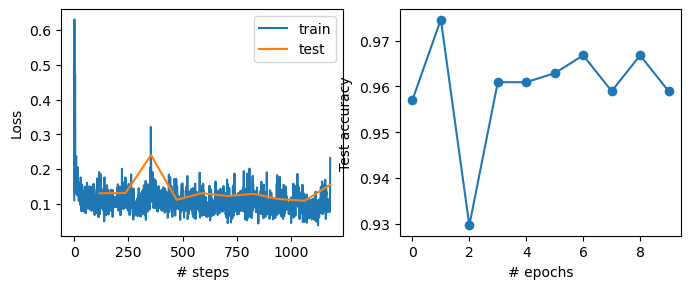

Maximum value of accuracy: 
 0.974609375
CPU times: user 10.5 s, sys: 4.42 s, total: 14.9 s
Wall time: 59.3 s


In [ ]:
%%time
_, test_accuracy = train(model, num_epoch=10, batch_size=512, loss_fn=loss_fn, device=device)
assert max(test_accuracy) >= 0.96

In [ ]:
## nn.Modules

class Net(nn.Module):
    def __init__(self): # CONSTRUCTOR: building blocks
        super(Net, self).__init__()
        self.n = 100
        self.fc1 = nn.Linear(784, self.n)
        self.fc2 = nn.Linear(self.n, 10)

    def forward(self, x): # FORWARD: Connection of building blocks
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model2 = Net().to(device)

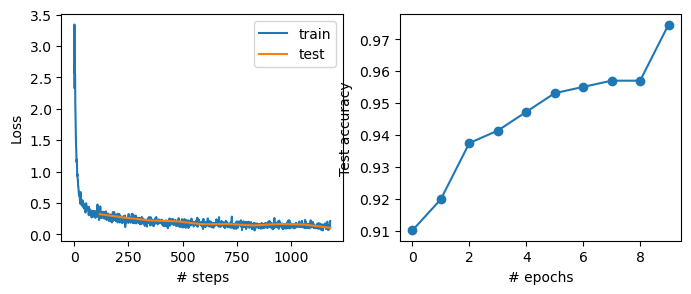

Maximum value of accuracy: 
 0.974609375
CPU times: user 10.3 s, sys: 4.26 s, total: 14.6 s
Wall time: 1min 2s


In [ ]:
%%time
_, test_accuracy = train(model2, num_epoch=10, batch_size=512, loss_fn=loss_fn, device=device)
assert max(test_accuracy) >= 0.96